In [1]:
# In this notebook, we will train a decision tree model
# to predict future plant stage given this year's habitat,
# stage, and size data

In [1]:
# To begin, import necessary libraries and data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
train = pd.read_csv('Train.csv')
val = pd.read_csv('Validation.csv')

In [2]:
# Encode categorical variables to work with DTC
from sklearn.preprocessing import OrdinalEncoder

# extract and encode categorical features
X_train_cat = train[['Habitat','Stage03']].to_numpy()
X_val_cat = val[['Habitat','Stage04']].to_numpy()

# encode categorical variables in X_train and X_val
enc = OrdinalEncoder()
X_train_cat = enc.fit_transform(X_train_cat)
X_val_cat = enc.transform(X_val_cat)

# Merge encoded categorical features with continuous features
X_train = train[['Length03','Width03','LeafArea03']].to_numpy()
X_val = val[['Length04','Width04','LeafArea04']].to_numpy()

print("X_train shape: ",X_train.shape)
print("X_val shape: ",X_val.shape)

X_train = np.append(X_train,X_train_cat,1)
X_val = np.append(X_val,X_val_cat,1)

print("X_train shape: ",X_train.shape)
print("X_val shape: ",X_val.shape)

Y_train = train['Stage04'].to_numpy()
Y_val = val['Stage05'].to_numpy()

X_train shape:  (1152, 3)
X_val shape:  (403, 3)
X_train shape:  (1152, 5)
X_val shape:  (403, 5)


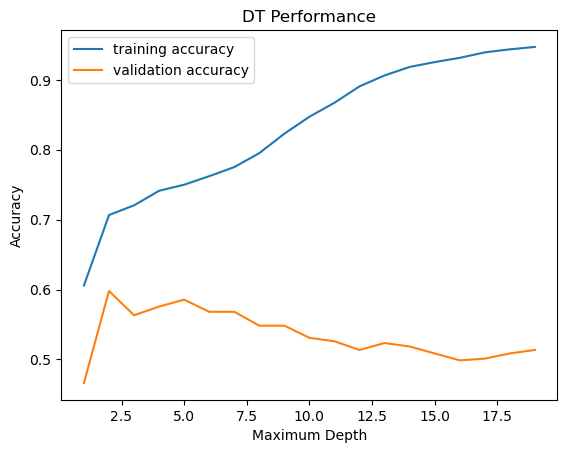

In [3]:
# import decision tree algorithm
from sklearn.tree import (DecisionTreeClassifier as DTC,plot_tree)
from sklearn.metrics import (accuracy_score)

# train decision tree algorithm
trainingAccuracy = []
validationAccuracy = []
depthValues = range(1,20)
for Depth in depthValues:
    tree = DTC(random_state = 0, max_depth = Depth, criterion = 'gini')
    tree.fit(X_train,Y_train)
    #trainingAccuracy.append(tree.score(X_train,Y_train))
    trainingAccuracy.append(accuracy_score(Y_train, tree.predict(X_train)))
    #validationAccuracy.append(tree.score(X_val,Y_val))
    validationAccuracy.append(accuracy_score(Y_val, tree.predict(X_val)))

# plot results
plt.plot(depthValues,trainingAccuracy,label = "training accuracy")
plt.plot(depthValues,validationAccuracy,label = "validation accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Maximum Depth")
plt.title("DT Performance")
plt.legend()
plt.savefig('dtcPerformance.png',bbox_inches='tight')
plt.show;

In [4]:
# let's re-train the model using the optimal depth
tree = DTC(random_state = 0,max_depth = 2,criterion = 'gini')
tree.fit(X_train,Y_train)
Y_predicted = tree.predict(X_val)
print("Training accuracy: ",accuracy_score(Y_train, tree.predict(X_train)))
print("Validation accuracy:", accuracy_score(Y_val, tree.predict(X_val)))

Training accuracy:  0.7065972222222222
Validation accuracy: 0.598014888337469


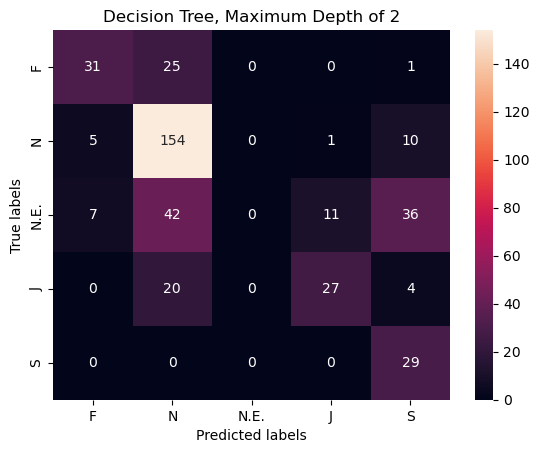

In [5]:
from sklearn import metrics
confusionMatrix = metrics.confusion_matrix(Y_val, Y_predicted)
cmDisplay = metrics.ConfusionMatrixDisplay(confusion_matrix = confusionMatrix)

import seaborn as sns
 
ax= plt.subplot()
sns.heatmap(confusionMatrix, annot=True,fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.xaxis.set_ticklabels(['F','N','N.E.','J','S']);
ax.yaxis.set_ticklabels(['F','N','N.E.','J','S']);
ax.set_title('Decision Tree, Maximum Depth of 2'); 
plt.savefig('dtc2CM.png',bbox_inches='tight')
plt.show()

In [6]:
# Get counts of each stage for true and predicted arrays
True_unique_values, True_counts = np.unique(Y_val, return_counts=True)
Pred_unique_values, Pred_counts = np.unique(Y_predicted, return_counts = True)

# Align results in corresponding vectors
True_dict = {}
for value, count in zip(True_unique_values, True_counts):
    True_dict[value] = count
    
Pred_dict = {}
for value, count in zip(Pred_unique_values, Pred_counts):
    Pred_dict[value] = count

True_dist = np.zeros(5)
Pred_dist = np.zeros(5)
idx = 0
for value in True_unique_values:
    if value in True_dict.keys():
        True_dist[idx] = True_dict[value]
    else:
        True_dist[idx] = 0
    if value in Pred_dict.keys():
        Pred_dist[idx] = Pred_dict[value]
    else:
        Pred_dist[idx] = 0
    idx += 1
    

In [7]:
print("Order of elements in population vector:\n",True_unique_values)
print("True distribution:\n",True_dist)
print("Predicted distribution:\n",Pred_dist)

Order of elements in population vector:
 ['flowering' 'nonflowering' 'not emerged' 'oneleaf' 'seedling']
True distribution:
 [ 57. 170.  96.  51.  29.]
Predicted distribution:
 [ 43. 241.   0.  39.  80.]


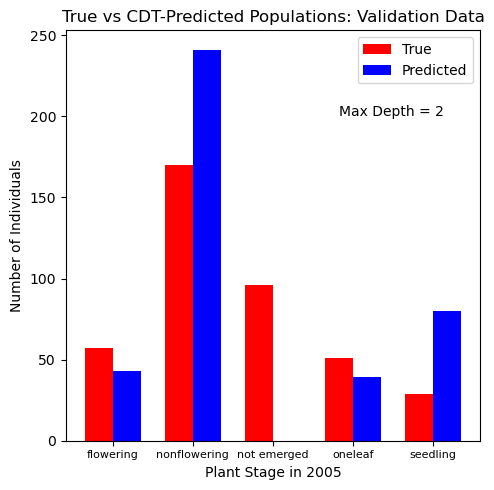

In [8]:
# Visualize predicted and true populations
# create plot
fig, ax = plt.subplots(figsize=(5, 5))
bar_width = 0.35
X = np.arange(5)

p1 = plt.bar(X, True_dist, bar_width, color='r',label='True')

# The bar of second plot starts where the first bar ends
p2 = plt.bar(X + bar_width, Pred_dist, bar_width,
color='b',
label='Predicted')

plt.xlabel('Plant Stage in 2005')
plt.ylabel('Number of Individuals')
plt.text(X[3],200,"Max Depth = 2")
plt.title('True vs CDT-Predicted Populations: Validation Data')
plt.xticks(X + (bar_width/2),True_unique_values, fontsize = 8)
plt.legend()

plt.tight_layout()
plt.savefig('dtcValPerformDepth2.png', bbox_inches='tight')
plt.show();

# Technically, this was the model's performance on the validation data. We will wait to test the model
# on the test data until the very end of the project.

In [9]:
# Let's calculate the 'error rate' we have been using
error = np.absolute(True_dist - Pred_dist)

# measure percentage of predicted population that is incorrect
error_rate = sum(error)/sum(Pred_dist)
print('Validation error rate: ',error_rate)

Validation error rate:  0.6054590570719603


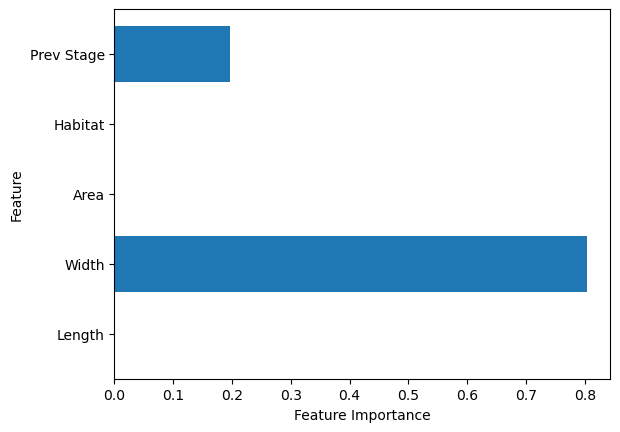

In [10]:
# Let's plot which features are most important
def plot_important_features(model):
    n_features = 5
    plt.barh(range(n_features),model.feature_importances_,align = 'center')
    plt.yticks(np.arange(n_features),
               ['Length','Width','Area','Habitat','Prev Stage'])
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    modName = str(model)
    title = modName + 'FeatrueImportance.png'
    plt.savefig(title,bbox_inches='tight')
    plt.show();

plot_important_features(tree)

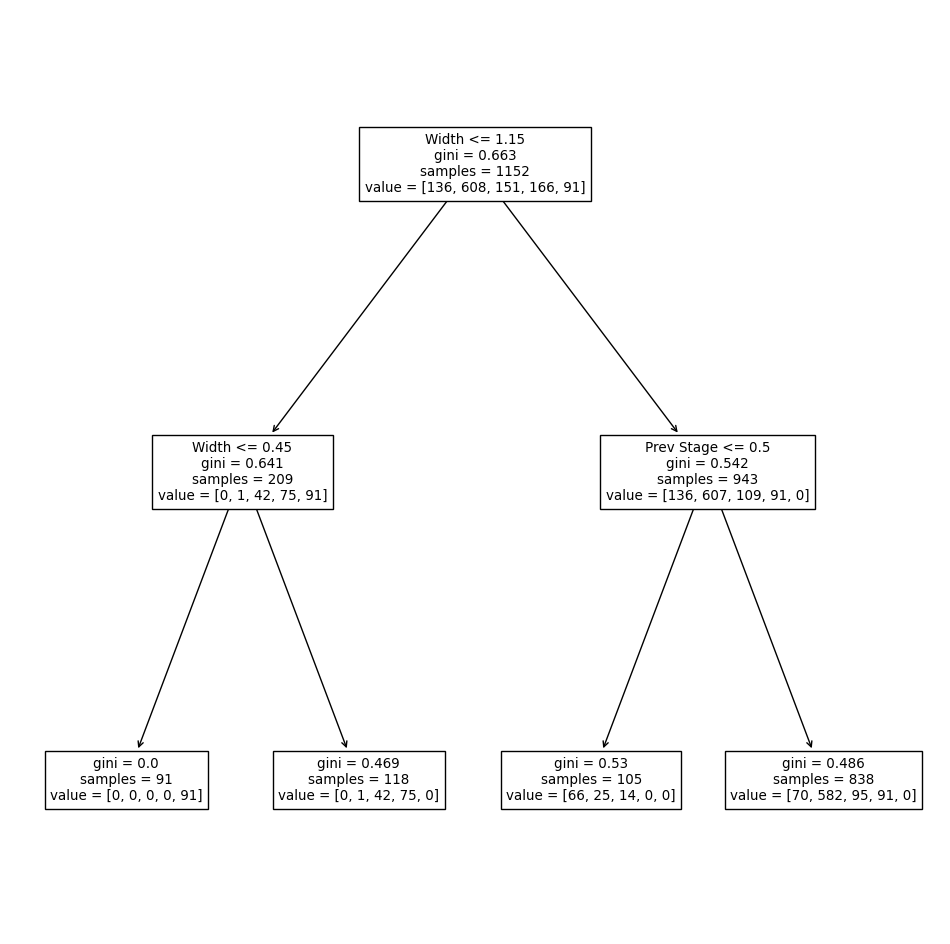

In [42]:
from sklearn.tree import plot_tree
from matplotlib.pyplot import subplots
ax = subplots(figsize=(12,12))[1]
plot_tree(tree,
          feature_names = ['Length','Width','Area','Habitat','Prev Stage'],
          ax=ax);
plt.savefig('classTree2.png', bbox_inches='tight')

In [14]:
# Let's repear the same exercise, except this time allow for a deeper tree
tree = DTC(random_state = 0,criterion = 'gini',max_depth = 10)
tree.fit(X_train,Y_train)
Y_predicted = tree.predict(X_val)
print("Training accuracy: ",accuracy_score(Y_train, tree.predict(X_train)))
print("Validation accuracy:", accuracy_score(Y_val, tree.predict(X_val)))

# Get counts of each stage for true and predicted arrays
True_unique_values, True_counts = np.unique(Y_val, return_counts=True)
Pred_unique_values, Pred_counts = np.unique(Y_predicted, return_counts = True)

# Align results in corresponding vectors
True_dict = {}
for value, count in zip(True_unique_values, True_counts):
    True_dict[value] = count
Pred_dict = {}
for value, count in zip(Pred_unique_values, Pred_counts):
    Pred_dict[value] = count

True_dist = np.zeros(5)
Pred_dist = np.zeros(5)
idx = 0
for value in True_unique_values:
    if value in True_dict.keys():
        True_dist[idx] = True_dict[value]
    else:
        True_dist[idx] = 0
    if value in Pred_dict.keys():
        Pred_dist[idx] = Pred_dict[value]
    else:
        Pred_dist[idx] = 0
    idx += 1

print("Order of elements in population vector:\n",True_unique_values)
print("True distribution:\n",True_dist)
print("Predicted distribution:\n",Pred_dist)

Training accuracy:  0.75
Validation accuracy: 0.5856079404466501
Order of elements in population vector:
 ['flowering' 'nonflowering' 'not emerged' 'oneleaf' 'seedling']
True distribution:
 [ 57. 170.  96.  51.  29.]
Predicted distribution:
 [ 38. 222.   5.  58.  80.]


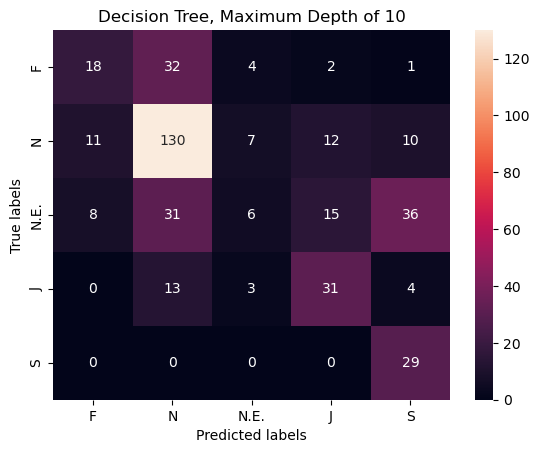

In [29]:
# Create confusion matrix
confusionMatrix = metrics.confusion_matrix(Y_val, Y_predicted)
cmDisplay = metrics.ConfusionMatrixDisplay(confusion_matrix = confusionMatrix)

import seaborn as sns
 
ax= plt.subplot()
sns.heatmap(confusionMatrix, annot=True,fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.xaxis.set_ticklabels(['F','N','N.E.','J','S']);
ax.yaxis.set_ticklabels(['F','N','N.E.','J','S']);
ax.set_title('Decision Tree, Maximum Depth of 10'); 
plt.savefig('dtcCM10.png',bbox_inches='tight')
plt.show()

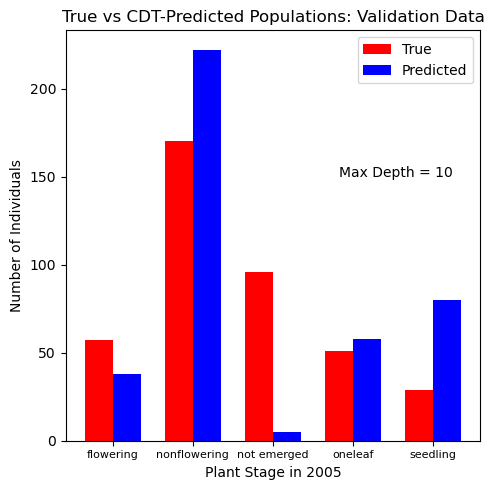

In [15]:
# Visualize predicted and true populations
# create plot
fig, ax = plt.subplots(figsize=(5, 5))
bar_width = 0.35
X = np.arange(5)

p1 = plt.bar(X, True_dist, bar_width, color='r',label='True')

# The bar of second plot starts where the first bar ends
p2 = plt.bar(X + bar_width, Pred_dist, bar_width,
color='b',
label='Predicted')

plt.xlabel('Plant Stage in 2005')
plt.ylabel('Number of Individuals')
plt.title('True vs CDT-Predicted Populations: Validation Data')
plt.xticks(X + (bar_width/2),True_unique_values, fontsize = 8)
plt.legend()
plt.text(X[3],150,"Max Depth = 10")
plt.tight_layout()
plt.savefig('dtcValPerform10.png', bbox_inches='tight')
plt.show();


In [18]:
# Let's calculate the 'error rate' we have been using
error = np.absolute(True_dist - Pred_dist)

# measure percentage of predicted population that is incorrect
error_rate = sum(error)/sum(Pred_dist)
print('Validation error rate: ',error_rate)

Validation error rate:  0.5459057071960298


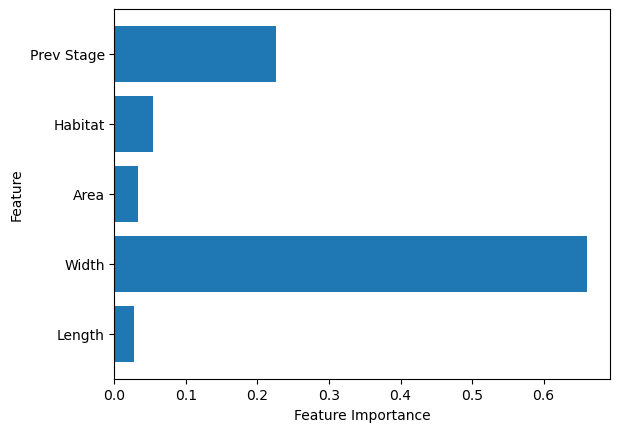

In [17]:
# Visualize which features are most important
plot_important_features(tree)